In [1]:
from numpy import *
from numpy.linalg import *

from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

%matplotlib notebook
from matplotlib.animation import FuncAnimation


Chariot Model
==============

We consider a mobile robot of "chariot" type, evolving in the plane.

  - From above, its frame appears to be a disk of diameter $D$. 
  
  - It has two fixed wheels (their orientation with respect to the frame does not change; there is no need for a steering wheel!). They are parallel and located at opposite ends of the frame (hence separated by a distance of $D$) ; these wheels have the common radius $R$.

  - The robot is symmetric with respect to the axis that joins the two wheels. For convenience, a green sticker is attached at the boundary of the frame on one side of this axis, on the robot axis of symmetry ; this side will is called the "front" of the robot, the point itself is called the "nose" of the robot. When we talk about the "left wheel" or the "right wheel", we assume that we are looking towards the front of the robot.

We will denote 

  - $(x, y)$ the coordinates of the wheel axis in the orthonormal and direct frame $(0, e_x, e_y)$ of the plane.
  
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the robot faces the right ($e_x$) and $\theta = \pi/2$ when he faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the robot moves forward.

### Parameter Definition


From now on, we assume that the frame diameter is $D = 1 \mbox{ m}$ and the wheel radius is $R = 10 \mbox{ cm}$.

🧩 Define the corresponding Python variables `D` and `R` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [2]:
D = 1
R = 10 / 100

### Graphical Representation

🧩 Implement a function `draw_robot` with arguments `x`, `y` and `theta` that draws the robot in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Represent the robot frame as a circle, the wheels as lines and the nose as an orange point.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [3]:
def draw_robot(x, y, theta):
    frame_radius = 0.5 * D
    translation = array([x, y])
    rotation = array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

    # Frame
    angle = linspace(0, 2*pi, 1000)
    plot(x + frame_radius * cos(angle), y + frame_radius * sin(angle), color="black")
    
    # Wheels
    wheel_left_xy_start = rotation @ [-R, frame_radius] + translation 
    wheel_left_xy_end = rotation @ [R, frame_radius] + translation
    wheel_right_xy_start = rotation @ [-R, -frame_radius] + translation
    wheel_right_xy_end = rotation @ [R, -frame_radius] + translation
    plot([wheel_left_xy_start[0], wheel_left_xy_end[0]], [wheel_left_xy_start[1], wheel_left_xy_end[1]], color="black",linewidth=5)
    plot([wheel_right_xy_start[0], wheel_right_xy_end[0]], [wheel_right_xy_start[1], wheel_right_xy_end[1]], color="black", linewidth=5)
    
    # Nose
    xn, yn = rotation @ [frame_radius, 0] + translation
    plot([xn], [yn], marker=".", color="orange", markersize=15)
    

🧩 Represent the robot in when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, -\pi), (-4, 4, -\pi), (-8, 4, -\pi)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin=-12, xmax=12, ymin=-9, ymax=9):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)
    plot([xmin, xmax], [0, 0], linestyle="-", color="grey")
    plot([0, 0], [ymin, ymax], linestyle="-", color="grey")

<IPython.core.display.Javascript object>


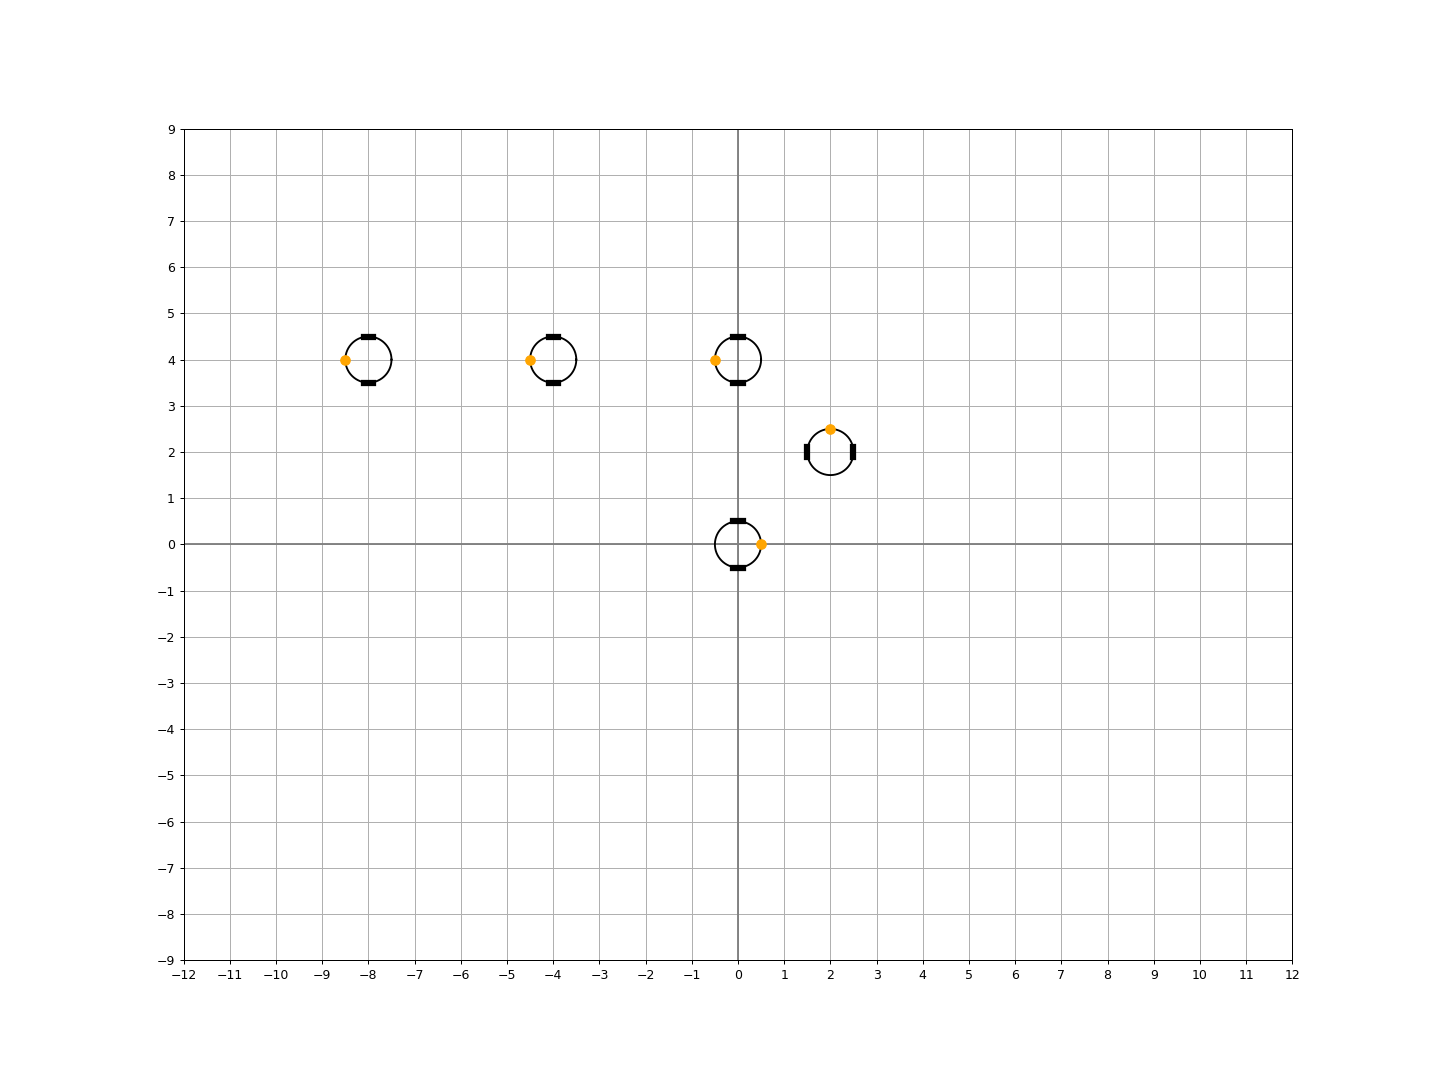

In [5]:
draw_arena()
draw_robot(0, 0, 0)
draw_robot(2, 2, pi/2)
draw_robot(0, 4, -pi)
draw_robot(-4, 4, -pi)
draw_robot(-8, 4, -pi)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the robot).
We also assume that the chariot wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

$$
\begin{array}{rcl}
\dot{x} &=& R  \frac{\omega_l + \omega_r}{2} \cos \theta \\
\dot{y} &=& R  \frac{\omega_l + \omega_r}{2} \sin \theta \\
\dot{\theta} &=& R  \frac{\omega_r - \omega_l}{D} \\
\end{array}
$$

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

The vector field is continuously differentiable as a composition of continuously differentiable functions, thus the IVP is well-posed.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

When the inputs are constant, it's pretty easy to prove that the derivatives of $x$, $y$ and $\theta$ with respect to $t$ are uniformly bounded ; thus $x$, $y$ and $\theta$ are bounded on any bounded time interval and therefore no finite-time blowup may happen: the maximal solution is global.

The situation is different with state-dependent inputs; for example with $\omega_r = - \omega_l = 0.5 D/R * \theta^2$, we end up with $\dot{\theta} = \theta(t)^2$ which has a finite-time blowup for some initial values of $\theta$. Thus, the maximal solution may not be global.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [6]:
def omega(t, xytheta):
    omega_l = 7.5 * pi
    omega_r = 12.5 * pi
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$, $(x,y,\theta)$ (and  -- implicitly -- the inputs $\omega$ computed by the function `omega`).

In [7]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = R * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = R * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = R * (omega_r - omega_l) / D
    return array([dx, dy, dtheta])

### Simulation Setup

🧩 Simulate the robot dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = 7.5 \pi$ and $\omega_r = 12.5 \pi$.
(Compute the dense outputs.)
   

In [8]:
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

<IPython.core.display.Javascript object>


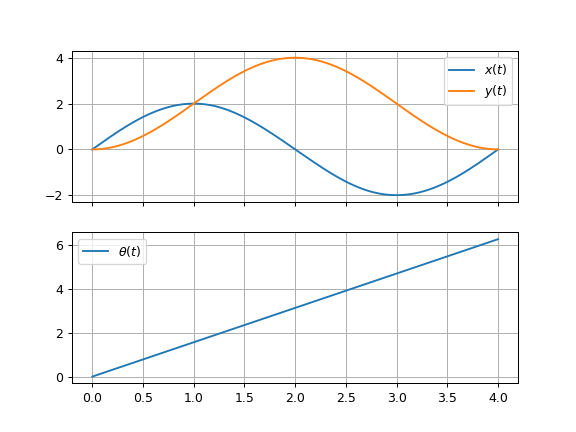

In [9]:
t = linspace(0.0, 4.0, 1000)
x, y, theta = r["sol"](t)
fig=figure()
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, x, label="$x(t)$")
ax1.plot(t, y, label="$y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta, label=r"$\theta(t)$")
ax2.legend()
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

<IPython.core.display.Javascript object>


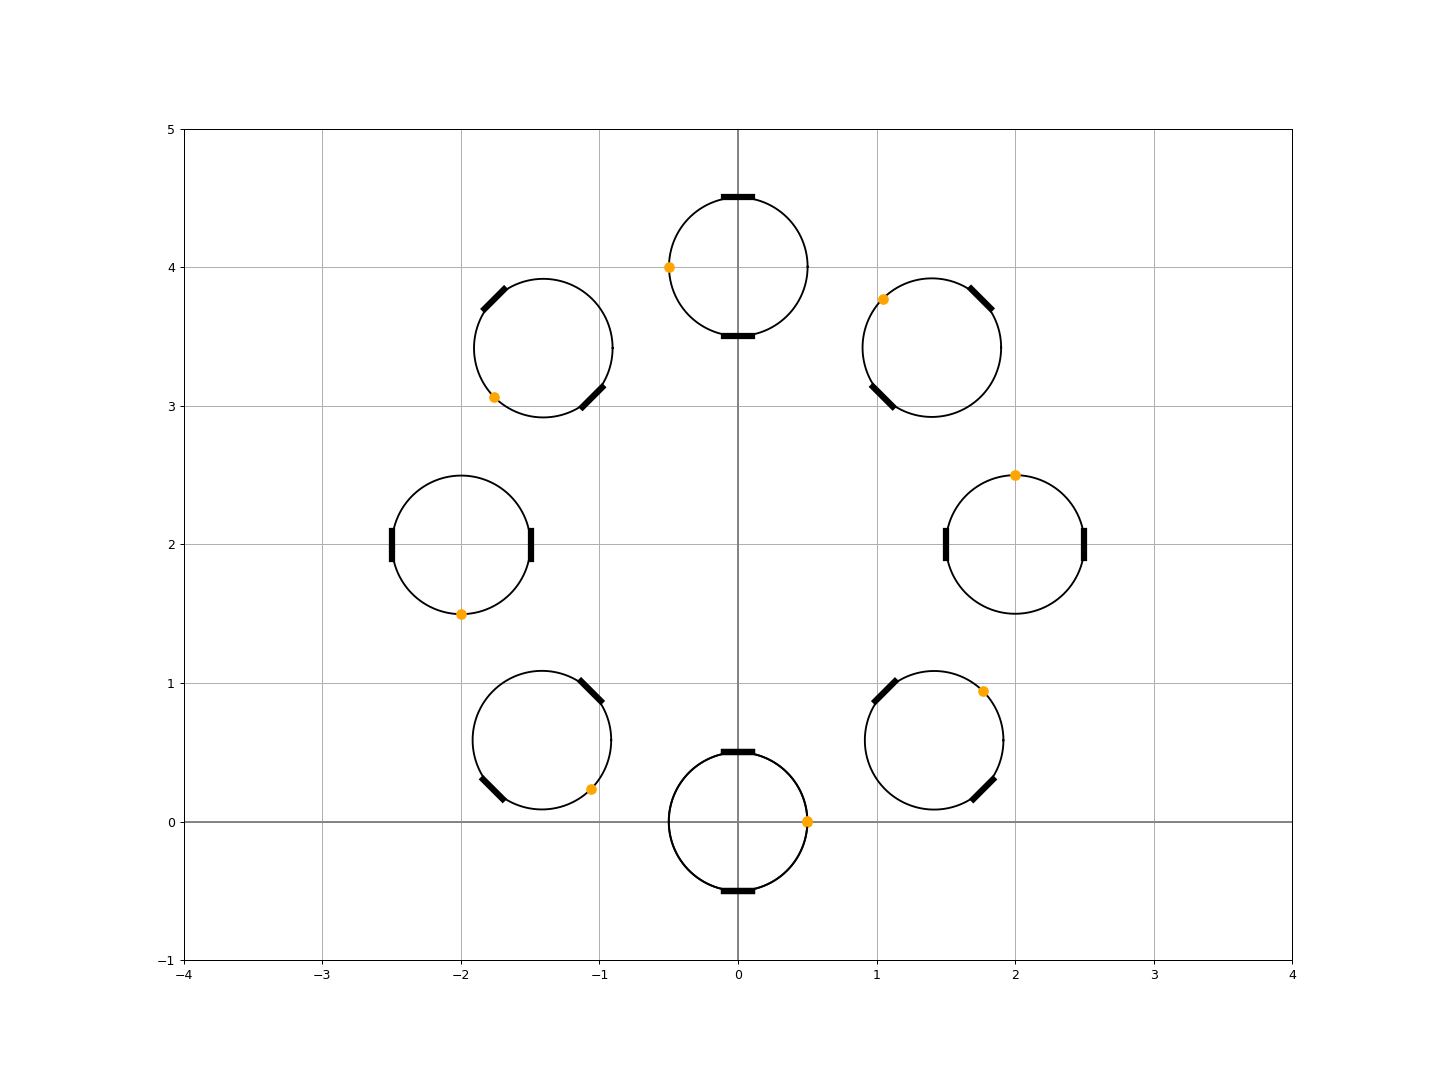

In [10]:
t = linspace(0.0, 4.0, 4*2+1)
sol_t = r["sol"](t)
draw_arena(-4, 4, -1, 5)
for x, y, theta in sol_t.T:
    draw_robot(x, y, theta)

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

$\theta(t) = 2 \pi / 4.0$, $x(t) = 2\sin(2\pi t / 4)$ and $y(t) = -2 \cos(2\pi t / 4)+2$.

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

<IPython.core.display.Javascript object>


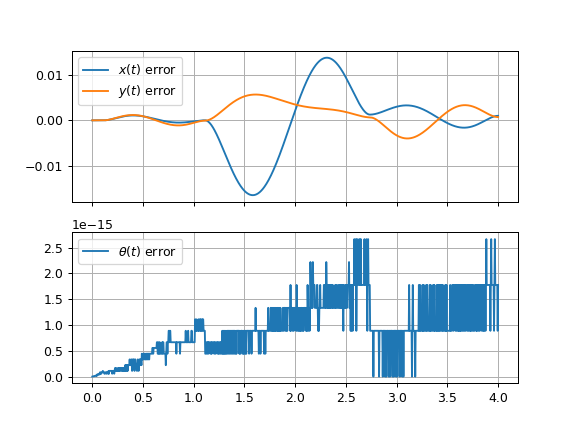

In [11]:
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure()
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
pass

🧩 If needed, adjust the simulation parameters until this error is uniformly less than $1e-5$.

<IPython.core.display.Javascript object>


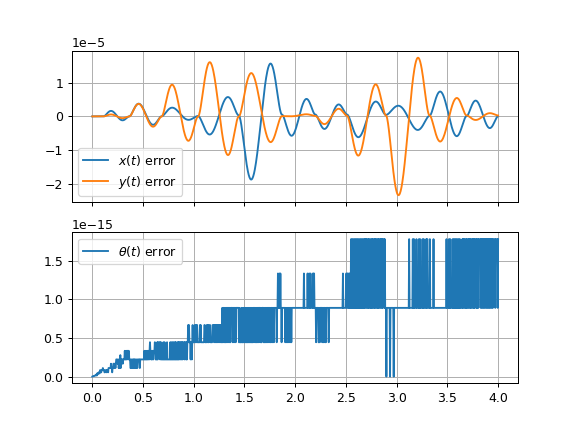

In [12]:
r = solve_ivp(fun=fun, t_span =(0.0, 4.0), y0=[0.0, 0.0, 0.0], rtol=1e-6, atol=1e-12, dense_output=True)
t = linspace(0.0, 4.0, 1000)
x_t, y_t, theta_t = r["sol"](t)
fig=figure()
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t , x_t - 2*sin(2*pi*t/4), label="$x(t)$ error")
ax1.plot(t , y_t + 2*cos(2*pi*t/4) - 2, label="$y(t)$ error")
ax1.legend()
ax2.grid(True)
ax2.plot(t, theta_t - 2*pi*t / 4.0, label=r"$\theta(t)$ error")
ax2.legend()
pass

Step2: implementing control
=====

Time dependent inputs
-----

We are going to simulate the case of the chariot controlled by time-dependent angular velocities $\omega_l$ and $\omega_r$. 

We want a simulation of 10s with the following inputs:
$$
    \omega_l(t) = \left\{
       \begin{array}{ll}
           2\pi & \mbox{when t $\leq$ 5s} \\
           \pi & \mbox{otherwise}
       \end{array}
    \right.
$$
and
$$
    \omega_r(t) = \left\{
       \begin{array}{ll}
           2\pi & \mbox{when t $\geq$ 5s} \\
           \pi & \mbox{otherwise}
       \end{array}
    \right.
$$

🧩 Provide the new definition of `omega`

In [13]:
def omega_l(t):
    
    if t<=5:
        omega_l = 2 * pi
    else :
        omega_l = pi
    
    return omega_l

def omega_r(t):
    
    if t>=5:
        omega_r = 2 * pi
    else :
        omega_r = pi
    
    return omega_r

def omega(t, xytheta):
    return array([omega_l(t), omega_r(t)])
   
  

🧩 Make a simulation of 10s of the robot with the previous input **without specifying** any parameter to improve the accuracy (`rtol`, `atol` and `max_step` at their default value) and by using the `dense_output` option to evaluate the solution at timesteps that will be defined later.

🗝️ **Hint.** This is not necessary to define again the function `fun`. If the previous cell has been correctly validated, `fun` will use the new definition of `omega`. 


In [14]:
r = solve_ivp(fun=fun, t_span=[0.0, 10.0], y0=[0.0, 0.0, 0.0], dense_output=True)

🧩 Use the simulation results to display the robot location every 1.5 seconds.

<IPython.core.display.Javascript object>


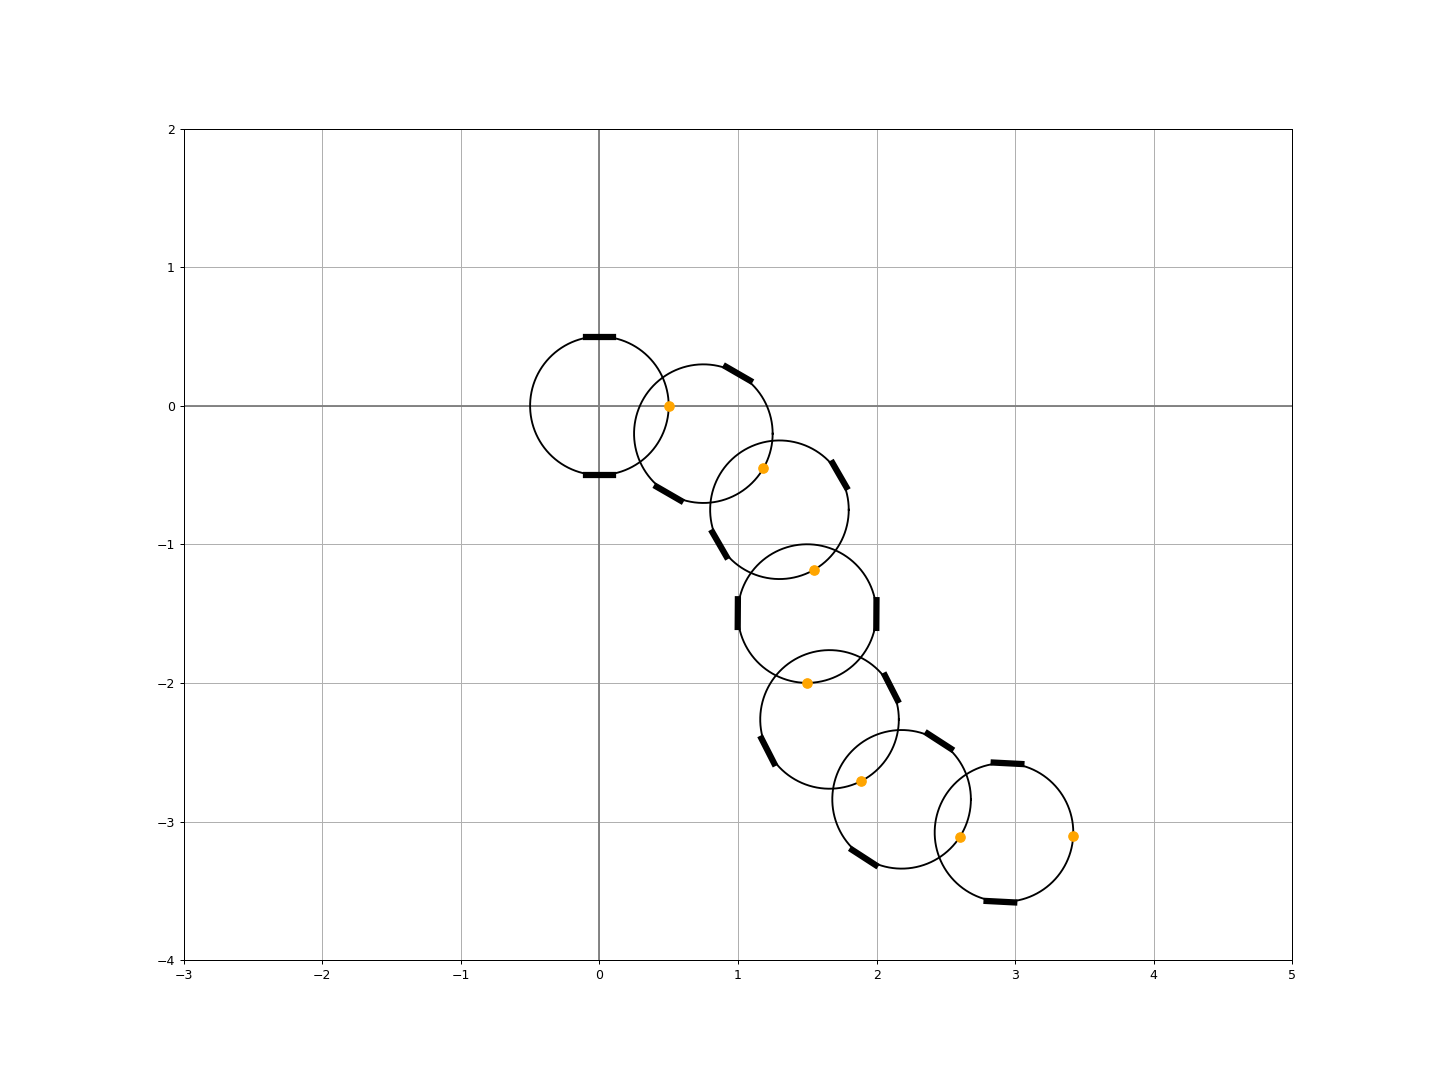

In [15]:
t = linspace(0.0, 10.0, int(10*2/3)+1)
sol_t = r["sol"](t)
draw_arena(-3, 5, -4, 2)
for x, y, theta in sol_t.T:
    draw_robot(x, y, theta)

## Analysis of the system at rest

### Equilibrium

🧩 Show that for a suitable (constant) choice $\omega_e \in \mathbb{R}^2$ of the vector input $\omega$, the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the mobile robot.



**Answer:**

We have $$f(t, X_e)=0 \iff \begin{cases} \omega_r = - \omega_l \\ \omega_r = \omega_l
\end{cases}$$

So $\omega_r = \omega_l = 0 $

This means that for $\omega_e=(0,0)$ the state $X_e = (x_e, y_e, \theta_e) = (0,0,0)$ is an equilibrium of the mobile robot.

🧩 Show that for any other $\omega_e$, the system has no equilibrium.

**Answer:**
If  $\omega_{e}\neq (0,0)$, we can define 2 cases :
* $ \exists \alpha \neq 0 $ such as $ \omega_{e}=(\alpha,\alpha)$ is an equilibrium of the mobile robot, which means that $\cos(\theta)=\sin(\theta)=0$, this is impossible because  $\cos^2(\theta)+\sin^2(\theta)=1$
* Otherwise $\dot{\theta} \neq 0~,\forall t$

There is no equilibrium for $\omega_{e}\neq (0,0)$

🧩 Conversely, if $\omega = \omega_e$, what are the other equilibria of the system?

**Answer:**

There is only one solution to the problem : s = (0,0). Any speed given that is different from 0, will allow the robot to move.

All states of the system are equilibria if the speed is s.


### Linearized System


Let $\omega = \omega_e$ and $X_e = (0,0,0)$.

Introduce the error variables $\Delta X = (\Delta x, \Delta y, \Delta \theta) = X - X_e$.

🧩 Compute the corresponding linearized dynamics and put it in standard form: compute the matrices $A$ and $B$ (remember that $\omega = (\omega_l,\omega_r)$.

**Answer:**

* Knowing : $A = 
\left[ 
\begin{array}{ccc}
\frac{\partial{f(X,\omega)}}{\partial{x}}  & \frac{\partial{f(X,\omega)}}{\partial{y}}  & \frac{\partial{f(X,\omega)}}{\partial{\theta}}
\end{array}
\right]
\$


* The non linearised system can be writen as : $f(X,\omega)=\begin{pmatrix}
       \frac{R}{2}(\omega_l+\omega_r)\cos(\theta)\\[0.3em]
       \frac{R}{2}(\omega_l+\omega_r)\sin(\theta)  \\[0.3em]
       \frac{R}{D}(\omega_r-\omega_l)        
     \end{pmatrix}$
     
     
     
     
     
     
* We get the following  : 
 $ A = \left[ 
\begin{array}{ccc}
0 & 0  & \frac{R}{2}(\omega_l-\omega_r)sin(\theta) \\
0 & 0 & \frac{R}{2}(\omega_l+\omega_r)cos(\theta) \\
0 & 0 & 0
\end{array}
\right]
\;$


* The linearised system can be written as the following knowing that $ $ theta=0, we get : 

$ A = \left[ 
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & \frac{R}{2}(\omega_l+\omega_r) \\
0 & 0 & 0
\end{array}
\right]
\;$


* Knowing that in our case omega=omega_e=(0,0), we get : 

$ A = \left[ 
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{array}
\right]
\;$

* Knowing : $ B = 
\left[ 
\begin{array}{cc}
\frac{\partial{f(X,\omega)}}{\partial{\omega_{r}}}  & \frac{\partial{f(X,\omega)}}{\partial{\omega_{l}}}
\end{array}
\right]
\;$



* Furthermore : 
 $ B = \left[ 
\begin{array}{cc}
\frac{R}{2}cos(\theta) & \frac{R}{2}cos(\theta)  \\
\frac{R}{2}sin(\theta) & \frac{R}{2}sin(\theta) \\
\frac{R}{D} & \frac{-R}{D} 
\end{array}
\right]
\;$



* And for theta=0,the matrix become : 
$B = \left[ 
\begin{array}{cc}
\frac{R}{2} & \frac{R}{2} \\
0 & 0  \\
\frac{R}{D} & \frac{-R}{D} 
\end{array}
\right]
\;$

### Stability of the linearized system

🧩 Is the linearized system asymptotically stable around $(0,0,0)$ when $\Delta \omega = (0,0)$ ?

🧩 Is the original system asymptotically stable ? Or even (locally) attractive ? 

**Answer:**
After replacing $\omega_l$ and $\omega_r$ by 0, we obtain $ A = \left[ 
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0
\end{array}
\right]
\;$ 
so $sp(A) = {0}$
The asymptotic stability condition is not confirmed since the values must be negative.
Thus, it's not attractive.

### Controllability of the linearized system

In this section, we consider only the linearized system defined by the matrices $A$ and $B$ computed previously:
$$
  \dot{\Delta X} = A.\Delta X + B\Delta \omega
$$

🧩 Is there an admissible trajectory that start with the state $X_0=(-2,0,0)$ and ends at origin after some time?  

**Answer:**


In [16]:
def x(t):
    return A * t*3 + B * t*2
def d2_x(t):
    return 6 * A * t + 2 * B
def u(t):
    return d2_x(t)
y0 = [-2, 0.0, 0.0]
def omega(t, xytheta):
    omega_l = 7.5 * pi
    omega_r = 12.5 * pi
    return array([omega_l, omega_r])
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = R * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = R * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = R * (omega_r - omega_l) / D
    return array([dx, dy, dtheta])
result = solve_ivp(fun, [0, 10], y0, dense_output=True)
result

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 62
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x00000220297AFE20>
   status: 0
  success: True
        t: array([0.00000000e+00, 6.36301304e-04, 6.99931434e-03, 7.06294447e-02,
       7.06930748e-01, 2.17517558e+00, 3.89236642e+00, 5.70635440e+00,
       7.53461863e+00, 9.35887455e+00, 1.00000000e+01])
 t_events: None
        y: array([[-2.00000000e+00, -1.99800100e+00, -1.97801145e+00,
        -1.77856597e+00, -2.08207388e-01, -2.54268302e+00,
        -2.33709323e+00, -1.10958858e+00, -3.33498197e+00,
        -3.10020842e-01, -2.00056543e+00],
       [ 0.00000000e+00,  9.98999668e-07,  1.20877752e-04,
         1.22960558e-02,  1.11146932e+00,  3.92461292e+00,
         2.99980097e-02,  3.78960221e+00,  5.12766830e-01,
         3.06744422e+00,  3.99877954e+00],
       [ 0.00000000e+00,  9.99499751e-04,  1.09944973e-02,
         1.10944472e-01,  1.1104

🧩 Is there an admissible trajectory that start with the state $X_0=(0,2,0)$ and ends at origin after some time?  

**Answer:**



In [17]:
def x(t):
    return A * t*3 + B * t*2
def d2_x(t):
    return 6 * A * t + 2 * B
def u(t):
    return d2_x(t)
y0 = [0.0, 2.0, 0.0]
def omega(t, xytheta):
    omega_l = 7.5 * pi
    omega_r = 12.5 * pi
    return array([omega_l, omega_r])
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    dx = R * 0.5 * (omega_l + omega_r) * cos(theta)
    dy = R * 0.5 * (omega_l + omega_r) * sin(theta)
    dtheta = R * (omega_r - omega_l) / D
    return array([dx, dy, dtheta])
result = solve_ivp(fun, [0, 10], y0, dense_output=True)
result

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 62
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x00000220297AE1D0>
   status: 0
  success: True
        t: array([0.00000000e+00, 2.84562736e-04, 3.13019010e-03, 3.15864637e-02,
       3.16149200e-01, 1.68829991e+00, 3.47745485e+00, 5.26115649e+00,
       6.95158058e+00, 8.58071321e+00, 1.00000000e+01])
 t_events: None
        y: array([[ 0.00000000e+00,  8.93980171e-04,  9.83374259e-03,
         9.91910935e-02,  9.52888539e-01,  9.40889460e-01,
        -1.46293670e+00,  1.83351309e+00, -1.99344974e+00,
         1.58103487e+00, -1.03787394e-04],
       [ 2.00000000e+00,  2.00000020e+00,  2.00002418e+00,
         2.00246123e+00,  2.24159063e+00,  5.76466592e+00,
         2.63910452e+00,  4.79751873e+00,  4.15318837e+00,
         2.77678484e+00,  6.00058671e+00],
       [ 0.00000000e+00,  4.46990100e-04,  4.91689110e-03,
         4.96159011e-02,  4.9660

🧩 Is the linearized system controllable?

**Answer:** 

def kallman(A,B):
    n=len(B)
    m=len(B[0])
    S=zeros((n,n*m))
    S[:,0:m]=B
    for i in range(1,n):
        C=S[:,(i-1)*m:(i)*m]
        S[:,i*m:(i+1)*m]=A@C
    return matrix_rank(S)
kalman(A,B)

The Kallman Matrix is of rank  $<3$  so the system is not controllable.

## Control on a straight line

### Admissible trajectories

Let $x_R(t) = v t$ and $y_R(t) = 0$ where $v \in \mathbb{R}$ and $v \neq 0$. 

🧩 Determine the set of trajectories $X_R(t) = (x_R(t), y_R(t), \theta_R(t))$ which are admissible and compute the corresponding reference control $\omega_{R}(t)$.

**Answer:**
We have  𝑥𝑅(𝑡)=𝑣𝑡 and 𝑦𝑅(𝑡)=0
So 𝑋𝑟(𝑡)=(𝑣𝑡,0,𝜃𝑟(𝑡)).
If we solve the equation:  𝑑𝑋𝑟(𝑡)𝑑𝑡=𝑓(𝑡,𝑋), we get 𝑓(𝑡,𝑋)=(𝑣𝑐𝑜𝑠(𝜃),𝑣𝑠𝑖𝑛(𝜃),𝜔) 

Then we find two possible trajectories for the system :

if $\theta = 2k\pi$ then $\omega_r(t) = (\frac{v}{R}, \frac{v}{R}) \Longrightarrow$ the robot moves forward.

and if $\theta = 2(k+1)\pi$ then $\omega_r(t) = (\frac{-v}{R}, \frac{-v}{R}) \Longrightarrow$ the robot moves backward.



### Linearized system

Let $\Delta X(t) = X(t) - X_R(t)$ and $\Delta \omega(t) = \omega(t) - \omega_R(t)$.

🧩 Compute the linearized dynamics of the system for the class of trajectory "moving forward".

**Answer:**
For the class of trajectory "moving forward", we have 𝜃=2𝑘𝜋 and 𝜔𝑟(𝑡)=(𝑣/𝑅,𝑣/𝑅)

However, we have: $$ A = \left[ 
\begin{array}{ccc}
0 & 0  & \frac{R}{2}(\omega_l-\omega_r)sin(\theta) \\
0 & 0 & \frac{R}{2}(\omega_l+\omega_r)cos(\theta) \\
0 & 0 & 0
\end{array}
\right]
\;$$

By replacing we get:

$$ A = \left[ 
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & \frac{R}{2}(\frac{v}{R}+\frac{v}{R}) \\
0 & 0 & 0
\end{array}
\right]
= \left[ 
\begin{array}{ccc}
0 & 0 & 0 \\
0 & 0 & v \\
0 & 0 & 0
\end{array}
\right]$$

🧩 Is the system asymptotically stable, with $\Delta\omega(t)=0$?

🧩 Is the system attractive, with $\Delta\omega(t)=0$?

**Answer:**

We have  𝑠𝑝(𝐴)=0  The asymptotic stability condition is not confirmed since the values must be negative

Therefore, it's not attractive neither.

🧩 Show that the linearized system is controllable.

**Answer:**



In [35]:
#we take a random vaue of v
v=10

M=B
M=c_[B, A @ B, matrix_power(A,2) @  B]

print(M)
print(matrix_rank(M))

[[ 0.05        0.05        0.          0.          0.          0.        ]
 [ 0.          0.          0.27777778 -0.27777778  0.          0.        ]
 [ 0.1        -0.1         0.          0.          0.          0.        ]]
3


We get $
  \mathrm{rang} \, \left[B, AB, A^{2} B\right] = 3
  $ which means our system is controllable.

### Linearized system implementation
In the sequel, we will use  𝑣=10𝑘𝑚/ℎ 

🧩 Implement and print the matrices  𝐴  and  𝐵

In [36]:
#we should convert the speed from km/h to m/s
v=10/3.6

A = array([[0, 0, 0], [0, 0, v], [0, 0, 0]])
B = array([[R/2, R/2], [0, 0], [R/D, -R/D]])

print(A)
print(B)

[[0.         0.         0.        ]
 [0.         0.         2.77777778]
 [0.         0.         0.        ]]
[[ 0.05  0.05]
 [ 0.    0.  ]
 [ 0.1  -0.1 ]]


The linear model as to be fed with some $\Delta\omega$ input. Like for the non linear system, we define a function $\Delta\omega(t,\Delta_X)$ that computes the input of the linearized system. For example, if we do not want any correction to the reference input, we will have:

In [37]:
def deltaOmega(t,deltaX):
    return array([0,0,0])

🧩 Implement a function `lin_fun(t, deltaX)` that computes $\dot{\Delta X}$ given the time $t$, $\Delta X$ (and  -- implicitly -- the inputs $\Delta\omega$ computed by the function `deltaOmega`).

In [38]:
def lin_fun(t,deltaX):
    
    deltaX_point=A@deltaX+B@deltaOmega(t,deltaX)
    
    return  deltaX_point

### Controller Design on the linearized system

🧩 Implement a process that computes a gain matrix $K$ that places the poles of the linearized system at some arbitrary location. For this question, we will chose 3 real poles with an absolute value close to 0.3.

Then, print the effective poles of the system: 

$$
\dot{\Delta X}= A.\Delta X + B\Delta\omega
$$
with
$$
\Delta\omega = -K.\Delta X
$$

In [39]:
poles = [-0.299,- 0.3, -0.311]  #valeurs propres 
K = place_poles(A, B, poles).gain_matrix
print(K)
eig,_= eig(A-B@K) 
print(eig)

[[ 2.99999998  0.16701843  3.04671056]
 [ 3.00000001 -0.16774197 -3.05328944]]


TypeError: 'numpy.ndarray' object is not callable

🧩 Simulate the linearized system during 10s, with an initial condition $\Delta X(0) = (0,2,0)$.

In [41]:
def deltaOmega(t,deltaX):
    deltaOmega=-K@deltaX
    return deltaOmega



delta_X0=[0,2,0]
t_span = [0, 10]
result = solve_ivp(fun= lin_fun, t_span=t_span, y0=delta_X0, dense_output= True, max_step = 0.1)
result

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 608
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000002202FC2C370>
   status: 0
  success: True
        t: array([ 0.        ,  0.01492858,  0.11492858,  0.21492858,  0.31492858,
        0.41492858,  0.51492858,  0.61492858,  0.71492858,  0.81492858,
        0.91492858,  1.01492858,  1.11492858,  1.21492858,  1.31492858,
        1.41492858,  1.51492858,  1.61492858,  1.71492858,  1.81492858,
        1.91492858,  2.01492858,  2.11492858,  2.21492858,  2.31492858,
        2.41492858,  2.51492858,  2.61492858,  2.71492858,  2.81492858,
        2.91492858,  3.01492858,  3.11492858,  3.21492858,  3.31492858,
        3.41492858,  3.51492858,  3.61492858,  3.71492858,  3.81492858,
        3.91492858,  4.01492858,  4.11492858,  4.21492858,  4.31492858,
        4.41492858,  4.51492858,  4.61492858,  4.71492858,  4.81492858,
        4.91492858,  5.01492858,  5

🧩 Plot the values of $\Delta x(t)$, $\Delta y(t)$ and $\Delta\theta(t)$ (**plot $\Delta\theta(t)$ in degrees**)

<IPython.core.display.Javascript object>


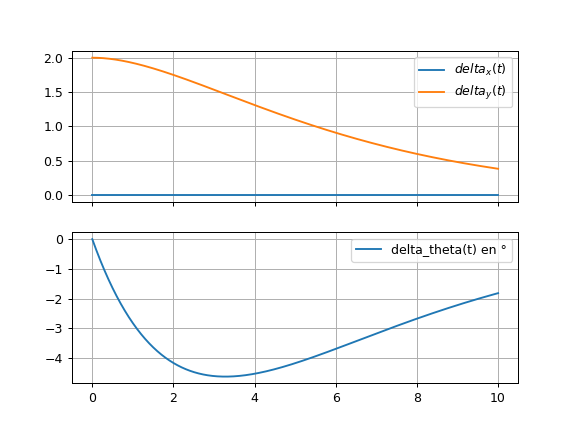

In [42]:
t = linspace(0.0,10 , 1000)

delta_x, delta_y, delta_theta = result["sol"](t)
fig=figure()
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, delta_x, label="$delta_x(t)$")
ax1.plot(t, delta_y, label="$delta_y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, delta_theta*(180/np.pi), label="delta_theta(t) en °")
ax2.legend()
pass

🧩 Why is it important to check that $\Delta\theta(t)$ stays small ?

**Answer:**

Δ𝜃(𝑡) should stay small to guarantee the system stability

🧩 Compute the corresponding values of $\Delta\omega_l,\Delta\omega_r$ and store them in the Python variables `dOmega_l`, `dOmega_r`

In [43]:
def deltaOmega(t,deltaX):
    deltaOmega=-K@deltaX
    return deltaOmega

deltaX=(delta_x,delta_y,delta_theta)

dOmega_l=deltaOmega(t,deltaX)[0]
dOmega_r=deltaOmega(t,deltaX)[1]

dOmega_l,dOmega_r


(array([-3.34036862e-01, -3.32001822e-01, -3.29976086e-01, -3.27959616e-01,
        -3.25952376e-01, -3.23954327e-01, -3.21965432e-01, -3.19985654e-01,
        -3.18014955e-01, -3.16053299e-01, -3.14100649e-01, -3.12156968e-01,
        -3.10222220e-01, -3.08296368e-01, -3.06379375e-01, -3.04471207e-01,
        -3.02571826e-01, -3.00681198e-01, -2.98799286e-01, -2.96926054e-01,
        -2.95061467e-01, -2.93205491e-01, -2.91358089e-01, -2.89519227e-01,
        -2.87688870e-01, -2.85866983e-01, -2.84053531e-01, -2.82248480e-01,
        -2.80451796e-01, -2.78663443e-01, -2.76883390e-01, -2.75111600e-01,
        -2.73348040e-01, -2.71592678e-01, -2.69845478e-01, -2.68106408e-01,
        -2.66375434e-01, -2.64652523e-01, -2.62937642e-01, -2.61230758e-01,
        -2.59531838e-01, -2.57840849e-01, -2.56157760e-01, -2.54482537e-01,
        -2.52815148e-01, -2.51155560e-01, -2.49503743e-01, -2.47859664e-01,
        -2.46223291e-01, -2.44594592e-01, -2.42973535e-01, -2.41360090e-01,
        -2.3

🧩 Compute $\omega_l,\omega_r$ and plot the translation speed of each wheels in km/h

<IPython.core.display.Javascript object>


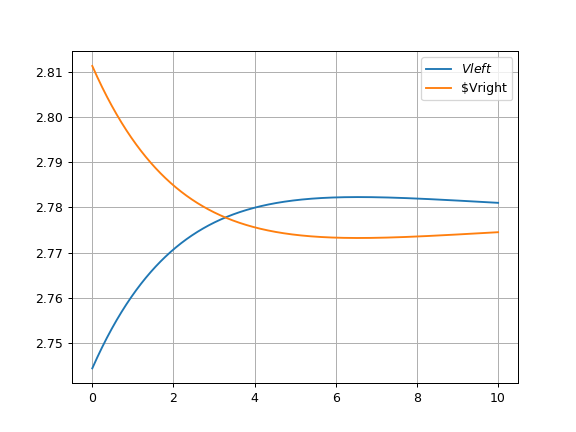

In [44]:
Omega_l=dOmega_l+v/R
Omega_r=dOmega_r+v/R

Vl=Omega_l*R
Vr=Omega_r*R

t = linspace(0.0,10 , 1000)
fig=figure()
ax1= fig.subplots()
ax1.grid(True)
ax1.plot(t, Vl, label="$Vleft$")
ax1.plot(t, Vr, label="$Vright")
ax1.legend()



🧩 Are the control values consistent with what the robot should do to cancel the error?

**Answer:**


###  Controller Tuning



Tune the poles so that the actual location $(x, y)$ is within 10 cm of the desired location within 5 sec (**keep continue to simulate during 10sec**) and the linear velocity of each wheel never exceeds $15$ km/h. Plot the values of $\Delta x$ (in m), $\Delta y$ (in m), $\Delta \theta$ (in degrees), and the speed of each wheel (in km/h)

🗝️ **Hint.** To answer this question, you can copy/paste the code of the previous questions to generate the appropriate plots.


In [45]:
poles=[-1.0,-2.0,-3.0]
K=place_poles(A,B,poles).gain_matrix

delta_X0=[0,2,0]
t_span = [0, 10]
result = solve_ivp(fun= lin_fun, t_span=t_span, y0=delta_X0, dense_output= True, max_step = 0.1)
result

t = linspace(0.0,10 , 1000)

delta_x, delta_y, delta_theta = result["sol"](t)
fig=figure()
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, delta_x, label="$delta_x(t)$")
ax1.plot(t, delta_y, label="$delta_y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, delta_theta*(180/np.pi), label="delta_theta(t) en °")
ax2.legend()
pass


TypeError: 'numpy.ndarray' object is not callable

In [46]:


poles = [-0.299,- 0.3, -0.311]  #valeurs propres 
K = place_poles(A, B, poles).gain_matrix
print(K)
eig,_= eig(A-B@K) 
print(eig)

t = linspace(0.0,10 , 1000)

delta_x, delta_y, delta_theta = result["sol"](t)
fig=figure()
ax1, ax2 = fig.subplots(2, 1, sharex=True)
ax1.grid(True)
ax1.plot(t, delta_x, label="$delta_x(t)$")
ax1.plot(t, delta_y, label="$delta_y(t)$")
ax1.legend()
ax2.grid(True)
ax2.plot(t, delta_theta*(180/np.pi), label="delta_theta(t) en °")
ax2.legend()
pass

[[ 2.99999998  0.16701843  3.04671056]
 [ 3.00000001 -0.16774197 -3.05328944]]


TypeError: 'numpy.ndarray' object is not callable

<IPython.core.display.Javascript object>


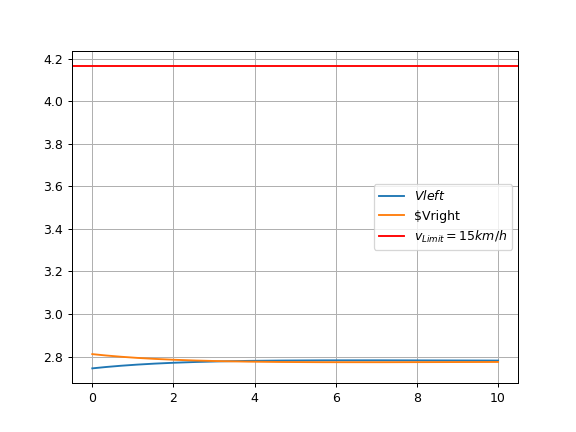

In [47]:
Omega_l=dOmega_l+v/R
Omega_r=dOmega_r+v/R

Vl=Omega_l*R
Vr=Omega_r*R

t = linspace(0.0,10 , 1000)
fig=figure()
ax1= fig.subplots()
ax1.grid(True)
ax1.plot(t, Vl, label="$Vleft$")
ax1.plot(t, Vr, label="$Vright")
axhline(y=15.0/3.6,color="red",label="$v_{Limit}=15km/h$")
ax1.legend()


### Controller validation

The goal of this part is to test the controller on the **true** non linear system.
The idea is the following:
  - We are going to simulate the original `fun` function
  - We need to define a new version of the function `omega` that computes the wheel velocities. Basically, the following steps will be necessary:
    1. Compute $\Delta X(t)$
    1. Compute $\Delta\omega(t)$
    1. Compute $\omega(t)$ thanks to $\Delta\omega(t)$ and $\omega_R(t)$
    
🧩 Implement the new version of `omega`

In [ ]:
def omega(t,xytheta):
    pass

🧩 Simulate the true system during 10sec

In [ ]:
pass

🧩 Use the simulation results to display the robot location every 1 second.

In [ ]:
pass

🧩 Plot the variables $x(t)$, $y(t)$, $\theta(t)$

In [ ]:
pass